## 2024 Crime Types by Month (12 Maps)

In [ ]:
import pandas as pd
import folium
import os
import zipfile
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

# Load data
df = pd.read_csv("final_crime_data_F.csv")

# Assign the most likely crime type per row
def get_crime_type(row):
    crime_types = ['Person', 'Property', 'Society', 'Unknown']
    return crime_types[pd.Series([row[ct] for ct in crime_types]).idxmax()]

df['Crime_Type'] = df.apply(get_crime_type, axis=1)

# Split data
train_df = df[df['Year'].isin([2022, 2023])]
predict_df = df[df['Year'] == 2024].copy()

# Encode target labels
le = LabelEncoder()
train_df['Crime_Label'] = le.fit_transform(train_df['Crime_Type'])

# Train the model
features = ['Lat', 'Lon', 'Month', 'Hour', 'Day_of_Week', 'Bus_Stop_Distance']
X_train = train_df[features]
y_train = train_df['Crime_Label']
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predict 2024
predict_df['Predicted_Crime_Type'] = le.inverse_transform(clf.predict(predict_df[features]))

# Count crime types per month
monthly_crime_counts = predict_df.groupby(['Month', 'Predicted_Crime_Type']).size().unstack(fill_value=0)

# Define color scheme
crime_color_map = {
    'Person': 'red',
    'Property': 'blue',
    'Society': 'orange',
    'Unknown': 'gray'
}

# Create folder for maps
output_dir = "updated_crime_prediction_maps"
os.makedirs(output_dir, exist_ok=True)
map_files = []

# Generate map for each month with crime type counts in legend
for month in sorted(predict_df['Month'].unique()):
    month_df = predict_df[predict_df['Month'] == month]
    crime_map = folium.Map(location=[month_df['Lat'].mean(), month_df['Lon'].mean()], zoom_start=11)

    # Add each point
    for _, row in month_df.iterrows():
        folium.CircleMarker(
            location=[row['Lat'], row['Lon']],
            radius=3,
            color=crime_color_map[row['Predicted_Crime_Type']],
            fill=True,
            fill_opacity=0.6
        ).add_to(crime_map)

    # Add crime counts to legend
    crime_counts = monthly_crime_counts.loc[month]
    legend_items = ''.join([
        f"&nbsp;<i style='color:{crime_color_map[crime]};'>●</i> {crime}: {count}<br>"
        for crime, count in crime_counts.items()
    ])
    legend_html = f"""
    <div style="position: fixed;
    bottom: 50px; left: 50px; width: 180px; height: auto;
    border:2px solid grey; z-index:9999; font-size:14px;
    background-color:white; padding: 5px;">
    &nbsp;<b>Crime Type Legend - {month} </b><br>
    {legend_items}
    </div>
    """
    crime_map.get_root().html.add_child(folium.Element(legend_html))

    map_file = f"{output_dir}/Crime_Map_Month_{month}.html"
    crime_map.save(map_file)
    map_files.append(map_file)

# Zip all maps
zip_path = "Predicted Crime Maps 2024 B.zip"
with zipfile.ZipFile(zip_path, 'w') as zipf:
    for file in map_files:
        zipf.write(file, arcname=os.path.basename(file))

# Also export predictions
predict_df.to_csv("predicted_crimes_2024_B.csv", index=False)

print("Zipped maps: Predicted Crime Maps 2024 B.zip")
print("Prediction data: predicted_crimes_2024_B.csv")


<ipython-input-2-3a12fd740ed6>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['Crime_Label'] = le.fit_transform(train_df['Crime_Type'])


Zipped maps: Predicted Crime Maps 2024 B.zip
Prediction data: predicted_crimes_2024_B.csv


## Heat Map of Crime Spots in 2024 (1 File)

In [ ]:
import pandas as pd
import folium
from folium.plugins import HeatMap
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

# Load your dataset
df = pd.read_csv("final_crime_data_F.csv")

# Assign a crime type based on highest category flag
def get_crime_type(row):
    crime_types = ['Person', 'Property', 'Society', 'Unknown']
    return crime_types[pd.Series([row[ct] for ct in crime_types]).idxmax()]

df['Crime_Type'] = df.apply(get_crime_type, axis=1)

# Split into training (2022–2023) and prediction (2024)
train_df = df[df['Year'].isin([2022, 2023])]
predict_df = df[df['Year'] == 2024].copy()

# Encode crime type
le = LabelEncoder()
train_df['Crime_Label'] = le.fit_transform(train_df['Crime_Type'])

# Train the model
features = ['Lat', 'Lon', 'Month', 'Hour', 'Day_of_Week', 'Bus_Stop_Distance']
X_train = train_df[features]
y_train = train_df['Crime_Label']
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predict crime types for 2024
predict_df['Predicted_Crime_Type'] = le.inverse_transform(clf.predict(predict_df[features]))

# Group by zip code for sectioned heatmap
zip_grouped = predict_df.groupby('Zip Code')

# Count predicted crime types
crime_color_map = {
    'Person': 'red',
    'Property': 'blue',
    'Society': 'orange',
    'Unknown': 'gray'
}
crime_type_counts = predict_df['Predicted_Crime_Type'].value_counts().to_dict()

# Create base map
m = folium.Map(location=[predict_df['Lat'].mean(), predict_df['Lon'].mean()], zoom_start=11)

# Add heatmap layers per zip code
for zip_code, group in zip_grouped:
    heat_data = [[row['Lat'], row['Lon']] for _, row in group.iterrows()]
    HeatMap(heat_data, radius=10, blur=15, max_zoom=1).add_to(m)

    # Add a label for each zip code
    lat_center = group['Lat'].mean()
    lon_center = group['Lon'].mean()
    folium.map.Marker(
        [lat_center, lon_center],
        icon=folium.DivIcon(
            html=f"""<div style="font-size: 12px; color: white;"><b>{zip_code}</b></div>"""
        )
    ).add_to(m)

# Add legend with total crime counts
legend_items = ''.join([
    f"&nbsp;<i style='color:{crime_color_map[crime]};'>●</i> {crime}: {count}<br>"
    for crime, count in crime_type_counts.items()
])
legend_html = f"""
 <div style="position: fixed;
 bottom: 50px; left: 50px; width: 200px; height: auto;
 border:2px solid grey; z-index:9999; font-size:14px;
 background-color:white; padding: 10px;">
 <b>2024 Predicted Crime Types</b><br>
 {legend_items}
 </div>
"""
m.get_root().html.add_child(folium.Element(legend_html))

# Save map
m.save("2024 Crime Heat Map by Zip Code.html")



<ipython-input-53-b27689baf20f>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['Crime_Label'] = le.fit_transform(train_df['Crime_Type'])


## 2024 K Means Based on Crime Types (1 File - 16 clusters)

In [ ]:
import pandas as pd
import folium
from folium.plugins import HeatMap
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Load your dataset
df = pd.read_csv("final_crime_data_F.csv")

# Assign a primary crime type (optional, for other uses)
def get_crime_type(row):
    crime_types = ['Person', 'Property', 'Society', 'Unknown']
    return crime_types[pd.Series([row[ct] for ct in crime_types]).idxmax()]

df['Crime_Type'] = df.apply(get_crime_type, axis=1)

# Filter for 2024 data
df_2024 = df[df['Year'] == 2024].copy()
features_kmeans = df_2024[['Lat', 'Lon']]

# Apply KMeans clustering
k = 16  # You can tune this number
kmeans = KMeans(n_clusters=k, random_state=42)
df_2024['Cluster'] = kmeans.fit_predict(features_kmeans)

# Evaluate clustering quality
sil_score = silhouette_score(features_kmeans, df_2024['Cluster'])

# Create a Folium map
kmeans_map = folium.Map(location=[df_2024['Lat'].mean(), df_2024['Lon'].mean()], zoom_start=11)

# Assign colors to clusters
cluster_colors = [
    'red', 'green', 'blue', 'orange', 'purple', 'brown', 'pink', 'gray',
    'olive', 'cyan', 'magenta', 'lime', 'yellow', 'navy', 'maroon', 'salmon']


# Plot each point with zip code label as tooltip
for _, row in df_2024.iterrows():
    folium.CircleMarker(
        location=[row['Lat'], row['Lon']],
        radius=3,
        color=cluster_colors[row['Cluster'] % len(cluster_colors)],
        fill=True,
        fill_opacity=0.6,
        tooltip=f"Zip Code: {row['Zip Code']}"
    ).add_to(kmeans_map)

# Add a legend
legend_items = ''.join([
    f"&nbsp;<i style='color:{cluster_colors[i]};'>●</i> Cluster {i+1}<br>"
    for i in range(k)
])
legend_html = f"""
 <div style="position: fixed;
 bottom: 50px; left: 50px; width: 200px; height: auto;
 border:2px solid grey; z-index:9999; font-size:14px;
 background-color:white; padding: 10px;">
 <b>K-Means Clusters (2024)</b><br>
 {legend_items}
 <br><b>Silhouette Score:</b> {sil_score:.3f}
 </div>
"""
kmeans_map.get_root().html.add_child(folium.Element(legend_html))

# Save the map
kmeans_map.save("2024 KMeans Crime Clusters H.html")


## Classify Zip Codes with NN

In [ ]:
# Packages & Library
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from torch.utils.data import TensorDataset, DataLoader

# View data
df = pd.read_csv("final_crime_data_F.csv")

# Separate one-hot and numeric columns
one_hot_cols = ['Person', 'Property', 'Society', 'Unknown']
numeric_cols = [col for col in df.columns if col not in one_hot_cols + ['Zip Code']]

# Scale only numeric features
scaler = StandardScaler()
scaled_numeric = scaler.fit_transform(df[numeric_cols])
scaled_numeric_df = pd.DataFrame(scaled_numeric, columns=numeric_cols)

# Concatenate one-hot columns (unscaled) + scaled numeric columns
X = pd.concat([df[one_hot_cols].reset_index(drop=True), scaled_numeric_df.reset_index(drop=True)], axis=1)
y = df['Zip Code']

# Encode target labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X.values, y_encoded, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)



# Define the model
class ZipCodeClassifier(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(ZipCodeClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 124)
        self.fc3 = nn.Linear(124, 256)
        self.fc4 = nn.Linear(256, 512)
        self.fc5 = nn.Linear(512, 256)
        self.fc6 = nn.Linear(256, 124)
        self.fc7 = nn.Linear(124, 64)
        self.out = nn.Linear(64, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.relu(self.fc5(x))
        x = self.relu(self.fc6(x))
        x = self.relu(self.fc7(x))
        return self.out(x)

model = ZipCodeClassifier(input_dim=X_train.shape[1], output_dim=len(le.classes_))

# Train the model
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 100
for epoch in range(epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X_batch.size(0)
        _, predicted = torch.max(outputs, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

    epoch_loss = running_loss / total
    epoch_accuracy = correct / total
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")

# Evaluate and Show Predictions
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs, 1)
    accuracy = (predicted == y_test_tensor).float().mean()
    print(f"\n📉 Test Accuracy: {accuracy.item() * 100:.2f}%")

    # Show predictions
    predicted_zip = le.inverse_transform(predicted[:100].numpy())
    true_zip = le.inverse_transform(y_test_tensor[:100].numpy())
    print("\nSample Predictions:")
    for i in range(100):
        print(f"Predicted: {predicted_zip[i]}, Actual: {true_zip[i]}")

Epoch 1/200, Loss: 2.0147, Accuracy: 0.3739
Epoch 2/200, Loss: 0.8373, Accuracy: 0.7055
Epoch 3/200, Loss: 0.6583, Accuracy: 0.7729
Epoch 4/200, Loss: 0.6137, Accuracy: 0.7873
Epoch 5/200, Loss: 0.5466, Accuracy: 0.8105
Epoch 6/200, Loss: 0.5163, Accuracy: 0.8248
Epoch 7/200, Loss: 0.5012, Accuracy: 0.8288
Epoch 8/200, Loss: 0.4656, Accuracy: 0.8423
Epoch 9/200, Loss: 0.4508, Accuracy: 0.8496
Epoch 10/200, Loss: 0.4291, Accuracy: 0.8586
Epoch 11/200, Loss: 0.4375, Accuracy: 0.8527
Epoch 12/200, Loss: 0.4120, Accuracy: 0.8633
Epoch 13/200, Loss: 0.4122, Accuracy: 0.8644
Epoch 14/200, Loss: 0.3966, Accuracy: 0.8707
Epoch 15/200, Loss: 0.3899, Accuracy: 0.8713
Epoch 16/200, Loss: 0.3915, Accuracy: 0.8722
Epoch 17/200, Loss: 0.3660, Accuracy: 0.8779
Epoch 18/200, Loss: 0.3681, Accuracy: 0.8778
Epoch 19/200, Loss: 0.3640, Accuracy: 0.8816
Epoch 20/200, Loss: 0.3535, Accuracy: 0.8829
Epoch 21/200, Loss: 0.3386, Accuracy: 0.8905
Epoch 22/200, Loss: 0.3397, Accuracy: 0.8910
Epoch 23/200, Loss:

## Crime Near & Far Bus Visual

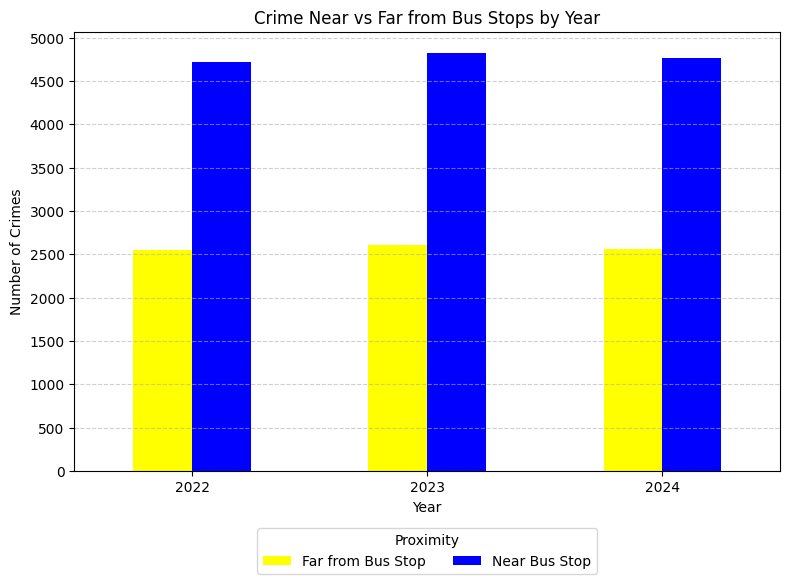

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load your dataset
crime_data = pd.read_csv("final_crime_data_F.csv")

# Step 1: Create binary indicator for proximity to bus stop
crime_data['Near_Bus_Stop'] = (crime_data['Bus_Stop_Distance'] <= 500).astype(int)
crime_data['Proximity'] = crime_data['Near_Bus_Stop'].map({1: 'Near Bus Stop', 0: 'Far from Bus Stop'})

# Step 2: Group by year and proximity
yearly_counts = crime_data.groupby(['Year', 'Proximity']).size().unstack(fill_value=0)

# Step 3: Plot as clustered bar chart
yearly_counts.plot(
    kind='bar',
    figsize=(8, 6),
    color=['yellow', 'blue'],
    edgecolor=None  # Remove border from bars
)

# Chart styling
plt.title('Crime Near vs Far from Bus Stops by Year')
plt.ylabel('Number of Crimes')
plt.yticks(np.arange(0,5500,500))

plt.xlabel('Year')
plt.xticks(rotation=0)
plt.legend(title='Proximity', loc='lower center', bbox_to_anchor=(0.5, -0.25), ncol=2)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()

# Show the chart
plt.show()


## 2024 Crime Heat Map of Day & Night

In [ ]:
import pandas as pd
import folium
from folium.plugins import HeatMap

# Load the dataset
crime_data = pd.read_csv('final_crime_data_F.csv')  # Update path as needed

# Filter for 2024 daytime crimes
daytime_2024 = crime_data[(crime_data['Year'] == 2024) & (crime_data['Day'] == 1)]

# Randomly sample 50% of the data
daytime_2024_sample = daytime_2024.sample(frac=0.5, random_state=42)

# Create base map
center_lat = daytime_2024['Lat'].mean()
center_lon = daytime_2024['Lon'].mean()
m_day_2024 = folium.Map(location=[center_lat, center_lon], zoom_start=11)

# Add title
title_html = '''
     <h3 align="center" style="font-size:20px"><b>2024 Daytime Crime Heatmap</b></h3>
     '''
m_day_2024.get_root().html.add_child(folium.Element(title_html))

# Add heatmap layer
heat_data = list(zip(daytime_2024['Lat'], daytime_2024['Lon']))
HeatMap(heat_data).add_to(m_day_2024)

# Add ZIP code labels
zip_centers = daytime_2024.groupby('Zip Code')[['Lat', 'Lon']].mean().reset_index()
for _, row in zip_centers.iterrows():
    folium.Marker(
        location=[row['Lat'], row['Lon']],
        icon=folium.DivIcon(html=f'<div style="font-size: 10pt">{int(row["Zip Code"])}</div>')
    ).add_to(m_day_2024)

m_day_2024


In [ ]:
import pandas as pd
import folium
from folium.plugins import HeatMap

# Filter for 2024 nighttime crimes
nighttime_2024 = crime_data[(crime_data['Year'] == 2024) & (crime_data['Night'] == 1)]

# Randomly sample 50% of the data
daytime_2024_sample = daytime_2024.sample(frac=0.5, random_state=42)


# Create base map
center_lat = nighttime_2024['Lat'].mean()
center_lon = nighttime_2024['Lon'].mean()
m_night_2024 = folium.Map(location=[center_lat, center_lon], zoom_start=11)

# Add title
title_html = '''
     <h3 align="center" style="font-size:20px"><b>2024 Nighttime Crime Heatmap</b></h3>
     '''
m_night_2024.get_root().html.add_child(folium.Element(title_html))

# Add heatmap layer
heat_data = list(zip(nighttime_2024['Lat'], nighttime_2024['Lon']))
HeatMap(heat_data).add_to(m_night_2024)

# Add ZIP code labels
zip_centers = nighttime_2024.groupby('Zip Code')[['Lat', 'Lon']].mean().reset_index()
for _, row in zip_centers.iterrows():
    folium.Marker(
        location=[row['Lat'], row['Lon']],
        icon=folium.DivIcon(html=f'<div style="font-size: 10pt">{int(row["Zip Code"])}</div>')
    ).add_to(m_night_2024)

m_night_2024
